## PostGIS

* PosgreSQLには地理情報に関する機能を集めたPostGIS呼ばれる拡張がある

* 参考
    * [PostGIS（地理情報システムを実現するための拡張モジュール](https://www.sraoss.co.jp/technology/postgresql/3rdparty/PostGIS.php)
    * [PostGISのよく使う機能をまとめた](http://d.hatena.ne.jp/EulerDijkstra/20131008/1381190780)
    * [PostGIS日本語マニュアル](https://www.finds.jp/docs/pgisman/1.5.1/ch01.html)
    
## Geometry データ型

* データ型
    * POINT
        * 点（位置、ランドマーク）を表す
    * LINESTRING
        * 線（道路や川）を表す
    * POLYGON
        * 面、多角形（領域、町丁目）を表す
    * これらの複数の要素をあらわす MULTIPOINT、MULTISTRING、MULTIPOLYGON
        * ただし、PostgreSQL のデータ型としては共通の geometry 型を使う
        * ある geometry 型カラムにおける内部的なデータ型は、型の属性として保持される
* 形式
    * WKT/WKB形式
    * EWKT/EWKB形式
        * 3次元対応やSRID（空間参照系の識別子）付記ができるように拡張されている
        * SRIDの例
            * 「4326」であればGPSで使用されるWGS84測地系に基づく緯度・経度であるという意味
            * SRIDがばらついていると位置情報がずれるので必ず統一する
        * 例1
            * 0101000020E610000000000000006061400000000000004240
                * バイナリ形式（ EWKB 形式）の 16 進数表現
            * POINT(139 36)
                * テキスト形式（EWKT形式）
        * 例2 (dev1のgeomのデータ) SRID付きポイントのEWKB
            * 010100002004120000F59ECA69CFD06040D55B035B250A4140
            * 先頭からバイト列を読み解く
                * 01 : エンディアン（01はリトルエンディアン）
                * 01000020 : ジオメトリタイプ
                    * 32ビット整数0x20000000を表す
                        * 0x20000001がSRIDが付いていることを示すフラグ
                * 04120000 : 整数
                    * SRIDを示す32ビット整数
                    * 32ビット整数0x00001204を表す
                    * 10進数にすると4612
                        * SRID=4612
                * F59ECA69CFD06040 : X値
                * D55B035B250A4140 : Y値
* 操作関数
    * ジオメトリー操作用の関数(ST_XXXXXX)
        * 地理的な検索や集計を行ったり、地図として表示させるポリゴンを取得
* 参考
    * [WKB/EWKBを見てみる](http://qiita.com/yellow_73/items/9d69ad9512c45481952f)

## Geography型

* 日本国内の地図を触っているだけなら必要なさそう？
* 厳密な距離を算出したいような場合必要かもしれない
    * Geography型は対応している関数が少ないのでGeometryで持っている方が無難
    * 必要な時だけGeometry型で持っているデータをGeographyに変換して操作するのがベター
    
## GeoJSON

* JSONを用いて空間データをエンコードし非空間属性を関連付けるファイル形式
* 属性にはポイント（住所や座標）、ライン（各種道路や境界線）、 ポリゴン（国や地域）などが含まれる
* 多くのGIS関連ソフトウェアが対応している
* Bing MapsやYahoo!、GoogleはAPIが対応している
* Googleマップにはライブラリを使用するかオブジェクトをインスタンス化することによって利用できる
    * https://github.com/JasonSanford/geojson-google-maps
* GitHubはGeoJSONのレンダリングに対応している

## 参考

* [初めて地図周りの技術に触れた時に作ったまとめ資料](http://qiita.com/laqiiz/items/7d256108920ff7afbf08)

## 変換

* EWKB -> EWKT -> GeoJSON
    * GoogleMapとかで使いやすくなる？
* ライブラリ
    * Shapely
        * 地理空間データ上で様々な計算を行なうためのPython用library
        * pipで入れる
    * fiona
        * Shapeファイルの読み込みで使う

* 参考
    * [WKT形式をGeoJSON形式に変換する](http://qiita.com/yuichy/items/14f2cb7d4ed113eca727)
    * [python + shapelyを使って東京都内だけに点を生成する](http://qiita.com/motokazu/items/e2668396b0723eafac5d)
    * [国土数値情報　ダウンロードサービス](http://nlftp.mlit.go.jp/ksj/index.html)
        * Shapeファイルをダウンロードする
    * [シェープファイル](https://ja.wikipedia.org/wiki/%E3%82%B7%E3%82%A7%E3%83%BC%E3%83%97%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB)
        * 他の地理情報システム(GIS)間でのデータの相互運用におけるオープン標準として用いられるファイル形式
    * [Conversion of a GeoJSON into EWKB format?](https://gis.stackexchange.com/questions/225196/conversion-of-a-geojson-into-ewkb-format)
        * PythonでWKT,EWKBを扱う

## QGIS

* 地理情報システムの閲覧、編集、分析機能を有するクロスプラットフォームのオープンソースソフトウェア・GISソフト
* 参考
    * [QGIS(Wikipedia)](https://ja.wikipedia.org/wiki/QGIS)

In [103]:
# データの扱いに必要なライブラリ
import pandas as pd

# ジオメトリを扱うためのライブラリ
from shapely import geos, wkb, wkt

# 初期設定はリトルエンディアン
geos.WKBWriter.defaults['big_endian'] = False

# GeoJSONを扱うためのライブラリ
from geojson import Point, MultiPoint

# jsonを扱うためのライブラリ
import json

## WKTをEWKBに変換

0101000000000000000000F03F0000000000000040
0
4612
010100002004120000000000000000F03F0000000000000040
0020000001000012043FF00000000000004000000000000000


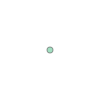

In [3]:
# WKTをEWKBに変換。リトルエンディアンのEWKBで単純にポイントをセット
p = wkt.loads('POINT Z(1 2)')
print(p.wkb_hex) 

# SRIDを設定できるようにする
geos.WKBWriter.defaults['include_srid'] = True

# デフォルトのSRIDの確認
print(geos.lgeos.GEOSGetSRID(p._geom))

# SRIDに4612をセット
geos.lgeos.GEOSSetSRID(p._geom, 4612)
print(geos.lgeos.GEOSGetSRID(p._geom))

# WEKBにSIDがセットされる
print(p.wkb_hex)

# ビッグエンディアンに変更することも可能
geos.WKBWriter.defaults['big_endian'] = True
print(p.wkb_hex)

# リトルエンディアンに戻す
geos.WKBWriter.defaults['big_endian'] = False
p

## WEKBからWKTに変換

In [4]:
geom = '010100002004120000F59ECA69CFD06040D55B035B250A4140'
shp = wkb.loads(geom, hex=True)
print(shp)

POINT (134.525319 34.079265)


## サンプルデータをcsvから読み込む

In [37]:
df = pd.read_csv("csv/geosample.csv")
df.head(5)

,id,geom,gps_time
0,658,010100002004120000F59ECA69CFD06040D55B035B250A...,2015-06-12 22:20:00
1,686,01010000200412000033535A7F4BD26040D97BF1457B08...,2015-06-12 22:48:00
2,673,01010000200412000088653387A4D16040FAB9A1293B09...,2015-06-12 22:35:00
3,679,010100002004120000EBAC16D8E3D1604050FC1873D708...,2015-06-12 22:41:00
4,649,010100002004120000F0DB10E335D06040A31F0DA7CC09...,2015-06-12 22:11:00


## WKTに変換した情報の列を追加

In [19]:
wkb.loads('010100002004120000F59ECA69CFD06040D55B035B250A4140', hex=True)
str(wkb.loads(df['geom'][0], hex=True))

'POINT (134.525319 34.079265)'

In [39]:
df = pd.read_csv("csv/geosample.csv")

wkt_list = []
for i in df['geom']:
    wkt_list.append(str(wkb.loads(i, hex=True)))

df_wkt = pd.DataFrame(wkt_list, columns=['wkt'])
df = pd.merge(df, df_wkt, how='inner', left_index=True, right_index=True).head(5)
df

,id,geom,gps_time,wkt
0,658,010100002004120000F59ECA69CFD06040D55B035B250A...,2015-06-12 22:20:00,POINT (134.525319 34.079265)
1,686,01010000200412000033535A7F4BD26040D97BF1457B08...,2015-06-12 22:48:00,POINT (134.571716 34.066262)
2,673,01010000200412000088653387A4D16040FAB9A1293B09...,2015-06-12 22:35:00,POINT (134.551334 34.072118)
3,679,010100002004120000EBAC16D8E3D1604050FC1873D708...,2015-06-12 22:41:00,POINT (134.559063 34.069075)
4,649,010100002004120000F0DB10E335D06040A31F0DA7CC09...,2015-06-12 22:11:00,POINT (134.506578 34.076558)


## geoJSONに変換

### サンプル

In [43]:
MultiPoint([(-155.52, 19.61), (-156.22, 20.74), (-157.97, 21.46)]) 

{"coordinates": [[-155.52, 19.61], [-156.22, 20.74], [-157.97, 21.46]], "type": "MultiPoint"}

In [62]:
[(-155.52, 19.61), (-156.22, 20.74), (-157.97, 21.46)]

[(-155.52, 19.61), (-156.22, 20.74), (-157.97, 21.46)]

### wktの値をMultiPointで読み込めるタプルの形式に変換

In [79]:
wkt_list[0]

'POINT (134.525319 34.079265)'

In [98]:
tuple(list(map(float, wkt_list[0].replace('POINT (','').replace(')','').split(" "))))

(134.525319, 34.079265)

In [99]:
wkt_list_for_geojson = []
for i in wkt_list:
    wkt_list_for_geojson.append(tuple(list(map(float, i.replace('POINT (','').replace(')','').split(" ")))))
wkt_list_for_geojson

[(134.525319, 34.079265),
 (134.571716, 34.066262),
 (134.551334, 34.072118),
 (134.559063, 34.069075),
 (134.506578, 34.076558),
 (134.536451, 34.077989),
 (134.534515, 34.078336),
 (134.539264, 34.077632),
 (134.509309, 34.076836),
 (134.528308, 34.078943),
 (134.549405, 34.072755),
 (134.537325, 34.077869),
 (134.530481, 34.078844),
 (134.547608, 34.074001),
 (134.55637, 34.071566),
 (134.562238, 34.068694),
 (134.56414, 34.068111),
 (134.532339, 34.078585),
 (134.558045, 34.071388),
 (134.565874, 34.067395),
 (134.526516, 34.079298),
 (134.518171, 34.07827),
 (134.560153, 34.068926),
 (134.516142, 34.077915),
 (134.520622, 34.078738),
 (134.573602, 34.065823),
 (134.511125, 34.077087),
 (134.523144, 34.079138),
 (134.574081, 34.065051),
 (134.570538, 34.06648),
 (134.544805, 34.076734),
 (134.552256, 34.07181),
 (134.558711, 34.070281),
 (134.541633, 34.077275)]

### geoJSONに変換

In [100]:
MultiPoint(wkt_list_for_geojson) 

{"coordinates": [[134.525319, 34.079265], [134.571716, 34.066262], [134.551334, 34.072118], [134.559063, 34.069075], [134.506578, 34.076558], [134.536451, 34.077989], [134.534515, 34.078336], [134.539264, 34.077632], [134.509309, 34.076836], [134.528308, 34.078943], [134.549405, 34.072755], [134.537325, 34.077869], [134.530481, 34.078844], [134.547608, 34.074001], [134.55637, 34.071566], [134.562238, 34.068694], [134.56414, 34.068111], [134.532339, 34.078585], [134.558045, 34.071388], [134.565874, 34.067395], [134.526516, 34.079298], [134.518171, 34.07827], [134.560153, 34.068926], [134.516142, 34.077915], [134.520622, 34.078738], [134.573602, 34.065823], [134.511125, 34.077087], [134.523144, 34.079138], [134.574081, 34.065051], [134.570538, 34.06648], [134.544805, 34.076734], [134.552256, 34.07181], [134.558711, 34.070281], [134.541633, 34.077275]], "type": "MultiPoint"}

### ファイルに出力

In [118]:
f = open("json/geosample.geojson", "w")
#json.dump(MultiPoint(wkt_list_for_geojson), f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
json.dump(MultiPoint(wkt_list_for_geojson), f, ensure_ascii=False, indent=4)